# DISTILBERT TRAINED ON LAST 512 TOKENS

In [ ]:
#!pip install transformers

In [ ]:
#Imports
from transformers import BertTokenizer, BertConfig, TFBertModel, TFBertForSequenceClassification
from transformers import DistilBertTokenizer, DistilBertConfig, TFDistilBertModel, TFDistilBertForSequenceClassification

import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import pandas as pd
import pickle
from sklearn.metrics import precision_recall_fscore_support, classification_report

# Graphing
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns 

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
# Configs

train_file = "train_80_10_10_doc_type.csv"
test_file = "test_80_10_10_doc_type.csv"
val_file = "val_80_10_10_doc_type.csv"

skip_lines = 6
max_length = 512
split_length = max_length-2

# BERT CONFIG

# BERT BASE
#bert_file = 'bert-base-uncased'
#tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
#bert_model = TFBertForSequenceClassification.from_pretrained(bert_file)

# DistilBert - BEST MODEL
bert_file = 'distilbert-base-uncased'
tokenizer = DistilBertTokenizer.from_pretrained(bert_file, do_lower_case=True)
bert_model = TFDistilBertForSequenceClassification.from_pretrained(bert_file)
#bert_model = TFDistilBertModel.from_pretrained(bert_file)

# BERT LARGE
#bert_file = 'bert-large-uncased'
#tokenizer = BertTokenizer.from_pretrained(bert_file, do_lower_case=True)
#bert_model = TFBertForSequenceClassification.from_pretrained(bert_file)



# Model Training
batch_size = 8
epochs = 5
learning_rate = 2e-5


In [ ]:
# Get the GPU device name.
device_name = tf.test.gpu_device_name()

# The device name should look like the following:
if device_name == '/device:GPU:0':
    print('Found GPU at: {}'.format(device_name))
else:
    raise SystemError('GPU device not found')

Found GPU at: /device:GPU:0


In [ ]:
# Function to get data
def get_data(fname):
    df = pd.read_csv(fname)
    df = df[['docid', 'cleaned_contents', 'Discrimination_Label','doc_type']]
    df = df.rename(columns = {'cleaned_contents':'text', 'Discrimination_Label':'label'})
    df.reset_index(inplace=True, drop=True)
    return df

In [ ]:
#Funtion to get the last 510 tokens only
def end_tokens(df):
  end_tokens = []

  for row in df['tokens']:
    end_tokens.append([row][0][-510:])
  return end_tokens

In [ ]:
#Function to create dictionary from lists for use in preparing tensorflow model input
def map_example_to_dict(input_ids, attention_masks, token_type_ids, label):
  return {
      "input_ids": input_ids,
      "token_type_ids": token_type_ids,
      "attention_mask": attention_masks,
  }, label

In [ ]:
# Function to explode out tokens seried into pre-defined chunk lengths and return as inputs to model 
def prepare_df(df):

  # add special tokens to beginning and end (assuming Bert tokenizer)
  for row in df['end_tokens']:
        row.insert(0,101)
        row.append(102)

  # create our input lists
  tokenized = df['end_tokens']
  input_ids = np.array([i + [0]*(split_length+2-len(i)) for i in tokenized.values])
  attention_mask = np.where(input_ids != 0, 1, 0)
  token_type_ids = np.where(input_ids != 0, 0, 0)
  labels = df['label'].tolist()

  # convert to tensorflow dataset object and return
  return tf.data.Dataset.from_tensor_slices((input_ids, attention_mask, token_type_ids, labels)).map(map_example_to_dict)

In [ ]:
# GET THE DATA
df_train = get_data(train_file)
df_test = get_data(test_file)
df_val = get_data(val_file)


In [ ]:
df_train = df_train.loc[df_train['doc_type'] != 'judgment'].reset_index()
df_test = df_test.loc[df_train['doc_type'] != 'judgment'].reset_index()
df_val = df_val.loc[df_train['doc_type'] != 'judgment'].reset_index()

In [ ]:
#remove double new lines
df_train['text'] = df_train['text'].replace('\n\s*\n', '\n',regex=True)
df_test['text'] = df_test['text'].replace('\n\s*\n', '\n',regex=True)
df_val['text'] = df_val['text'].replace('\n\s*\n', '\n',regex=True)

In [ ]:
# strip last n lines
df_train['text'] = df_train.apply(lambda L: L.text.rsplit("\n",skip_lines)[0], axis=1)
df_test['text'] = df_test.apply(lambda L: L.text.rsplit("\n",skip_lines)[0], axis=1)
df_val['text'] = df_val.apply(lambda L: L.text.rsplit("\n",skip_lines)[0], axis=1)

In [ ]:
# Tokenize data - capture all tokens. %%capture supresses message about length being too long
%%capture 
df_train['tokens'] = df_train['text'].apply((lambda x: tokenizer.encode(x, add_special_tokens=False,)))
df_val['tokens'] = df_val['text'].apply((lambda x: tokenizer.encode(x, add_special_tokens=False,)))
df_test['tokens'] = df_test['text'].apply((lambda x: tokenizer.encode(x, add_special_tokens=False,)))

In [ ]:
# Grab just the last n tokens (that is where the magic happens!)
df_train['end_tokens'] = end_tokens(df_train)
df_val['end_tokens'] = end_tokens(df_val)
df_test['end_tokens'] = end_tokens(df_test)

In [ ]:
# Create model input tensorflow dataset
ds_encode_val =  prepare_df(df_val).batch(batch_size)
ds_encode_train =  prepare_df(df_train).batch(batch_size)
ds_encode_test =  prepare_df(df_test).batch(batch_size)

In [ ]:
# THE MODEL
model = bert_model
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate, epsilon=1e-08)

# we do not have one-hot vectors, we can use sparce categorical cross entropy and accuracy
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')

#loss='categorical_crossentropy'
#metric=['accuracy']

model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

In [ ]:
# THE MODEL


In [ ]:
model.summary()

Model: "tf_distil_bert_for_sequence_classification"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
distilbert (TFDistilBertMain multiple                  66362880  
_________________________________________________________________
pre_classifier (Dense)       multiple                  590592    
_________________________________________________________________
classifier (Dense)           multiple                  1538      
_________________________________________________________________
dropout_19 (Dropout)         multiple                  0         
Total params: 66,955,010
Trainable params: 66,955,010
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Train (fine tune) the model
bert_history = model.fit(ds_encode_train, epochs=epochs, validation_data=ds_encode_val)

Epoch 1/5
61/61 [==============================] - 59s 966ms/step - loss: 0.6724 - accuracy: 0.6070 - val_loss: 0.6637 - val_accuracy: 0.6049
Epoch 2/5
61/61 [==============================] - 58s 952ms/step - loss: 0.6536 - accuracy: 0.6276 - val_loss: 0.6359 - val_accuracy: 0.6420
Epoch 3/5
61/61 [==============================] - 58s 955ms/step - loss: 0.6132 - accuracy: 0.6605 - val_loss: 0.6341 - val_accuracy: 0.6790
Epoch 4/5
61/61 [==============================] - 58s 956ms/step - loss: 0.5334 - accuracy: 0.7325 - val_loss: 0.6728 - val_accuracy: 0.6543
Epoch 5/5
61/61 [==============================] - 58s 956ms/step - loss: 0.4359 - accuracy: 0.8333 - val_loss: 0.8145 - val_accuracy: 0.6420


In [ ]:
# EVALUATE THE MODEL
model.evaluate(ds_encode_test)

11/11 [==============================] - 3s 254ms/step - loss: 0.6955 - accuracy: 0.6667


[0.6954775452613831, 0.6666666865348816]

In [ ]:
# Get Predictions
log_pred = model.predict(ds_encode_test)
y_pred = np.argmax(log_pred[0], axis=1)

In [ ]:
# Show classification report
print("DistilBert, standard inputs, no judgement docs, chunk size = ", split_length)
print(classification_report(df_test['label'], y_pred))

DistilBert, standard inputs, no judgement docs, chunk size =  510
              precision    recall  f1-score   support

           0       0.60      0.78      0.68        37
           1       0.76      0.57      0.65        44

    accuracy                           0.67        81
   macro avg       0.68      0.68      0.67        81
weighted avg       0.69      0.67      0.66        81



In [ ]:
# Show classification report
print("DistilBert, standard inputs, chunk size = ", split_length)
print(classification_report(df_test['label'], y_pred))

DistilBert, standard inputs, chunk size =  510
              precision    recall  f1-score   support

           0       0.60      0.78      0.68        37
           1       0.76      0.57      0.65        44

    accuracy                           0.67        81
   macro avg       0.68      0.68      0.67        81
weighted avg       0.69      0.67      0.66        81



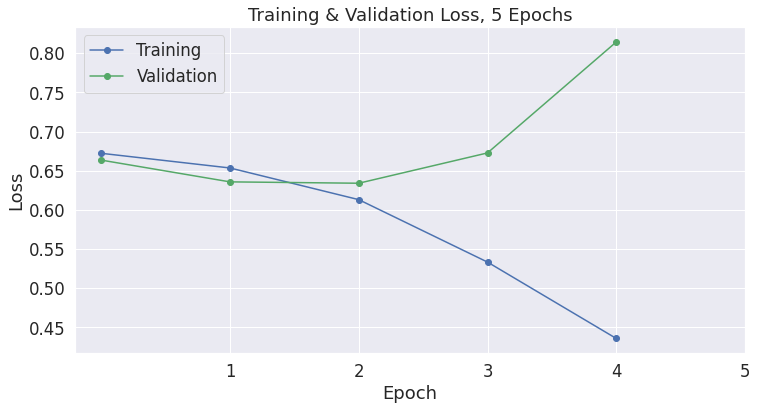

In [ ]:
# Plot the learning curve.

sns.set(style='darkgrid')
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

plt.plot(bert_history.history['loss'], 'b-o', label="Training")
plt.plot(bert_history.history['val_loss'], 'g-o', label="Validation")
plt.title("Training & Validation Loss, 5 Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4, 5])

plt.show()

In [ ]:
# Show classification report
print("DistilBert, standard inputs, chunk size = ", split_length)
print(classification_report(df_test['label'], y_pred))

DistilBert, standard inputs, chunk size =  510
              precision    recall  f1-score   support

           0       0.60      0.78      0.68        37
           1       0.76      0.57      0.65        44

    accuracy                           0.67        81
   macro avg       0.68      0.68      0.67        81
weighted avg       0.69      0.67      0.66        81



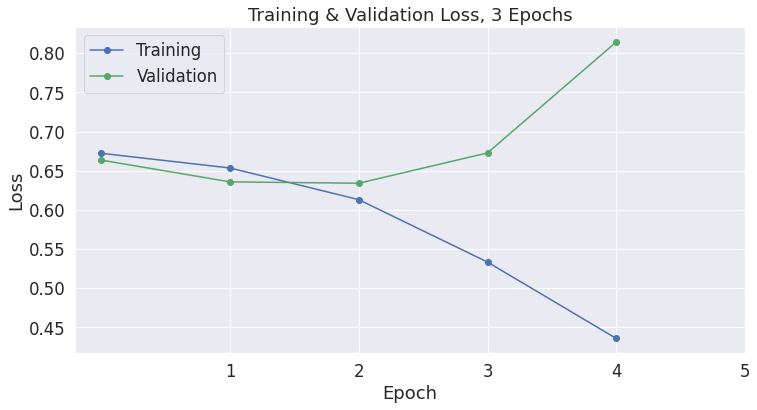

In [ ]:
# Plot the learning curve.

sns.set(style='darkgrid')
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

plt.plot(bert_history.history['loss'], 'b-o', label="Training")
plt.plot(bert_history.history['val_loss'], 'g-o', label="Validation")
plt.title("Training & Validation Loss, 3 Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4, 5])

plt.show()

In [ ]:
# Show classification report
print("DistilBert, standard inputs, chunk size = ", split_length)
print(classification_report(df_test['label'], y_pred))

DistilBert, standard inputs, chunk size =  510
              precision    recall  f1-score   support

           0       0.60      0.78      0.68        37
           1       0.76      0.57      0.65        44

    accuracy                           0.67        81
   macro avg       0.68      0.68      0.67        81
weighted avg       0.69      0.67      0.66        81



In [ ]:
# Show classification report
print("DistilBert, standard inputs, chunk size = ", split_length)
print(classification_report(df_test['label'], y_pred))

DistilBert, standard inputs, chunk size =  510
              precision    recall  f1-score   support

           0       0.77      0.65      0.71        37
           1       0.74      0.84      0.79        44

    accuracy                           0.75        81
   macro avg       0.76      0.74      0.75        81
weighted avg       0.76      0.75      0.75        81

